In [1]:
%load_ext autoreload
%autoreload 2
import os; import sys; sys.path.insert(0,'../')
import pandas as pd
import numpy as np
import tqdm
import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

import atomic.features as fs
import matplotlib.pyplot as plt
import pattern.vis as vis
import sklearn.mixture as mix
#import socceraction.atomic.labels as lab
import matplotsoccer as mps
import atomic.vaep as vaep

In [2]:
## Configure file and folder names
datafolder = "../data/private"
spadl_h5 = os.path.join(datafolder,"spadl-statsbomb.h5")
predictions_h5 = os.path.join(datafolder,"atomic-predictions.h5")

In [3]:
games = pd.read_hdf(spadl_h5,"games")
games = games[(games.competition_name == "Premier League")
             & (games.season_name == "2018/2019")]
print("nb of games:", len(games))

actiontypes = pd.read_hdf(spadl_h5, "atomic_actiontypes")
bodyparts = pd.read_hdf(spadl_h5, "bodyparts")

nb of games: 380


In [4]:
with pd.HDFStore(spadl_h5) as spadlstore,\
    pd.HDFStore(predictions_h5) as predstore:
    actions = []
    for game in tqdm.tqdm(games.itertuples()):
        a = spadlstore[f"atomic_actions/game_{game.game_id}"]
        p = predstore[f"game_{game.game_id}"]
        [a] = fs.play_left_to_right([a],game.home_team_id)
        a["is_home"] = a.team_id == game.home_team_id
        assert len(a) == len(p)
        a = pd.concat([a,p],axis=1)
        actions.append(a)
    actions = pd.concat(actions)
    actions = actions.merge(spadlstore["atomic_actiontypes"],how="left")
actions[:5]

380it [00:24, 15.52it/s]


,game_id,period_id,action_id,time_seconds,timestamp,team_id,player_id,x,y,dx,dy,type_id,bodypart_id,is_home,scores,concedes,type_name
0,14562.0,1.0,0,1.0,00:00:01.344,58.0,9923.0,52.058824,34.430380,-10.588235,-0.000000,0,0,False,0.000903,0.000402,pass
1,14562.0,1.0,1,1.5,00:00:02.117,58.0,9917.0,41.470588,34.430380,-0.000000,-0.000000,23,0,False,0.001126,0.000227,receival
2,14562.0,1.0,2,2.0,00:00:02.117,58.0,9917.0,41.470588,34.430380,-0.000000,-0.000000,21,0,False,0.001173,0.000301,dribble
3,14562.0,1.0,3,2.0,00:00:02.969,58.0,9917.0,41.470588,34.430380,-15.882353,-14.632911,0,0,False,0.000920,0.000423,pass
4,14562.0,1.0,4,3.0,00:00:04.338,58.0,9924.0,25.588235,19.797468,-0.000000,-0.000000,23,0,False,0.000650,0.000417,receival


In [5]:
#a = actions[(actions.scores > 0.4) & (actions.type_name =="dribble")]
#actions["vaep_value"] = actions.scores - actions.concedes
#actions["logscores"] = np.log(actions.scores)
#actions["logconcedes"] = np.log(actions.concedes)
#a["end_x"] = a.x + a.dx
#a["end_y"] = a.y + a.dy
#mps.actions(a[["x","y","end_x","end_y"]],zoom=True)

In [5]:
actions = pd.concat([actions,vaep.value(actions,actions.scores,actions.concedes)],axis=1)

In [6]:
actions.vaep_value

0          0.000000
1          0.000398
2         -0.000027
3         -0.000375
4         -0.000264
             ...   
1188665   -0.000124
1188666    0.002821
1188667    0.001966
1188668    0.001484
1188669   -0.000522
Name: vaep_value, Length: 1188670, dtype: float64

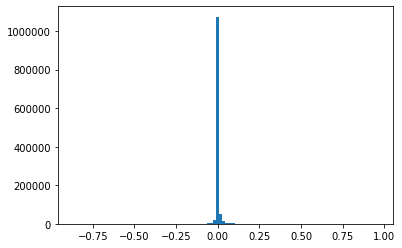

In [7]:
plt.hist(actions.vaep_value,bins=100)
plt.show()
# plt.hist(actions.logscores - actions.logconcedes,bins=100)
# plt.show()
# plt.hist(actions.logscores,bins=100)
# plt.show()
# plt.hist(actions.logconcedes,bins=100)
# plt.show()

In [8]:
# Make a nice action subset
import pattern.action as pat

a = actions[200000:400000].fillna(0)
a = pat.simplify(a)
#a["type_name"] = a.type_name.mask(~a.is_home,a.type_name + "_opp")
a["x"] = a.x.mask(a.type_name=="goal",105)
a["y"] = a.y.mask(a.type_name=="goal",32.5)
a["dx"] = a.dx.mask(a.type_name=="shot",105-a.x)
a["dy"] = a.dy.mask(a.type_name=="shot",32.5-a.y)

In [22]:
len(a.type_name.value_counts())

ty = a.type_name
nex = a
for i in range(10):
    nex = nex.shift(-1)
    ty = ty + nex.type_name
    vc = ty.value_counts()
    print(len(vc),len(vc)/(23*(23**(i+1))))
    print(vc[:3])

177 0.33459357277882795
passreceival       46224
receivaldribble    45619
dribblepass        45611
Name: type_name, dtype: int64
700 0.05753267033779896
passreceivaldribble    42486
receivaldribblepass    39047
dribblepassreceival    38685
Name: type_name, dtype: int64
2018 0.007211237810042131
passreceivaldribblepass        36529
dribblepassreceivaldribble     36324
receivaldribblepassreceival    33523
Name: type_name, dtype: int64
4622 0.0007181096470464673
receivaldribblepassreceivaldribble    31621
dribblepassreceivaldribblepass        31462
passreceivaldribblepassreceival       31396
Name: type_name, dtype: int64
8872 5.993141298323949e-05
passreceivaldribblepassreceivaldribble    29664
receivaldribblepassreceivaldribblepass    27656
dribblepassreceivaldribblepassreceival    27359
Name: type_name, dtype: int64
14977 4.398757067912622e-06
passreceivaldribblepassreceivaldribblepass        25949
dribblepassreceivaldribblepassreceivaldribble     25948
receivaldribblepassreceivaldribbl

In [23]:
#ac = a[a.type_name.isin(["cross","corner","throw_in","shot"])]
candidates = pat.candidates(a,["x","y","dx","dy"],20,True)
lns = {t : len(a[a.type_name==t]) for t in set(a.type_name)}

Training shot_penalty components:  95%|█████████▍| 18/19 [00:00<00:00, 89.02it/s] /home/tomd/software/miniconda3/envs/soccer/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:972: ConvergenceWarning: Number of distinct clusters (18) found smaller than n_clusters (19). Possibly due to duplicate points in X.
  return_n_iter=True)
Training goal components:   0%|          | 0/20 [00:00<?, ?it/s]/home/tomd/software/miniconda3/envs/soccer/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
/home/tomd/software/miniconda3/envs/soccer/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
Training goal components:  15%|█▌        | 3/20 [00:00<00:00, 18.68it/s]/home/tomd/software/mini

In [24]:
list((m.n_components,s) for t,m,s in candidates if t == "shot")

[(1, 6561.226568886268),
 (2, 6637.773704499532),
 (3, 6792.169091916396),
 (4, 6895.845981433842),
 (5, 6889.9525085444475),
 (6, 6906.416034554366),
 (7, 6908.213622980625),
 (8, 6917.0387697728975),
 (9, 6941.768809815771),
 (10, 6924.8014213486695),
 (11, 6936.017308381978),
 (12, 6940.93364274278),
 (13, 6951.786937928446),
 (14, 6965.5115169719975),
 (15, 6963.761090685122),
 (16, 6972.208289200045),
 (17, 6976.466074457193),
 (18, 6967.5212199132875),
 (19, 6990.980950611041),
 (20, 6988.6463796380895)]

In [38]:
#import np.linalg
def covarnorm(gmm):
    covars = gmm.covariances_
    s = 0
    for i in range(len(covars)):
        s += np.linalg.norm(np.diag(covars[i]))
    return s/len(covars)

In [ ]:
list((m.n_components,s) for t,m,s in normcandidates if t=="shot")

In [40]:
import cvxpy as cp

n = 100

normcandidates = [(t,m,
                   s/lns[t]*np.log(lns[t])#tnp.log(lns[t])
                  ) for t,m,s in candidates]

normcandidates = [(t,m,
                   -covarnorm(m)#*(lns[t])
                  ) for t,m,s in candidates]

selected_candidates = pat.ilp_select_candidates(normcandidates,n,verbose=False)

gmme = pat.GMMEnsemble(["x","y","dx","dy"#,"vaep_value"
                       ],{k:m for k,m,s in selected_candidates})
gmme.components()

{'throw_in': 9,
 'take_on': 6,
 'dribble': 3,
 'foul': 10,
 'interception': 7,
 'out': 3,
 'tackle': 4,
 'goalkick': 5,
 'bad_touch': 5,
 'red_card': 3,
 'yellow_card': 6,
 'owngoal': 1,
 'pass': 7,
 'clearance': 2,
 'shot': 2,
 'shot_penalty': 1,
 'receival': 6,
 'offside': 5,
 'cross': 2,
 'goal': 1,
 'corner': 3,
 'freekick': 8,
 'keeper_catch': 1}

In [18]:
np.argsort([3,2])

array([1, 0])

bad_touch 5 1605


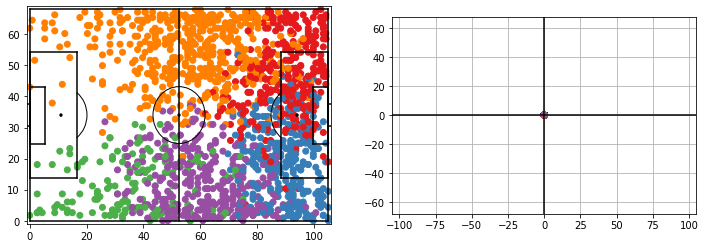

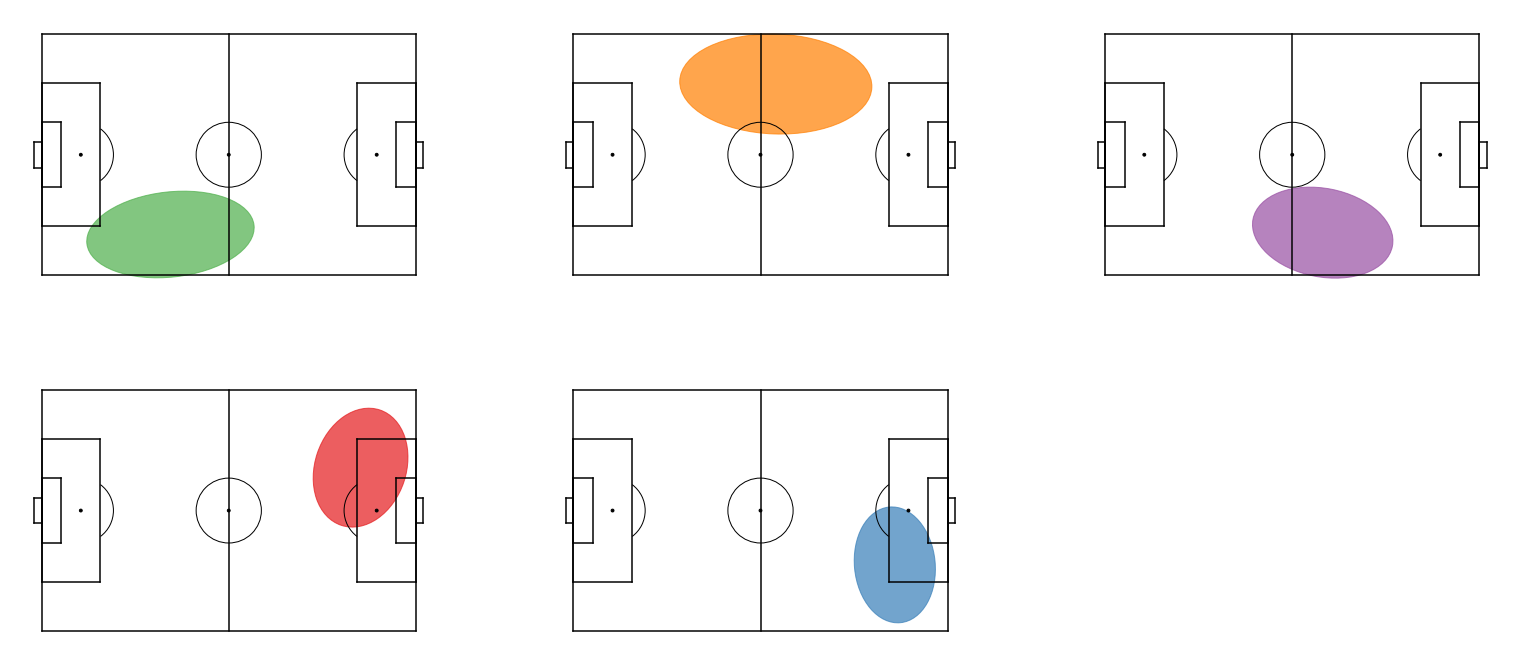

clearance 2 3336


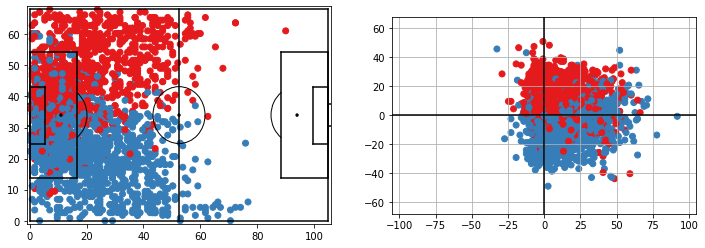

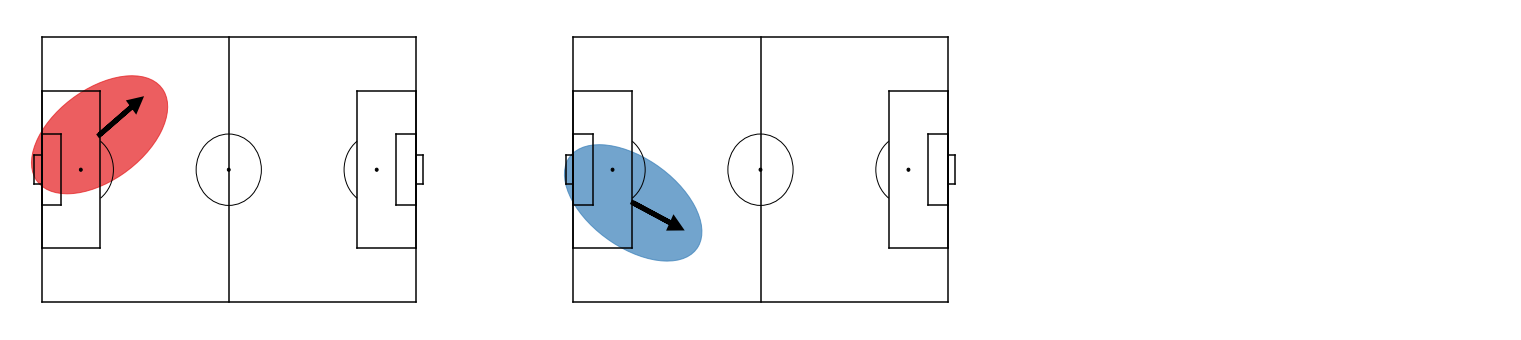

corner 3 650


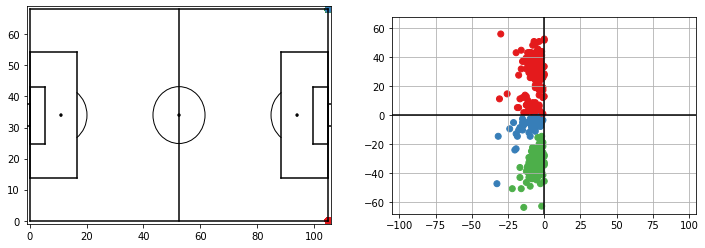

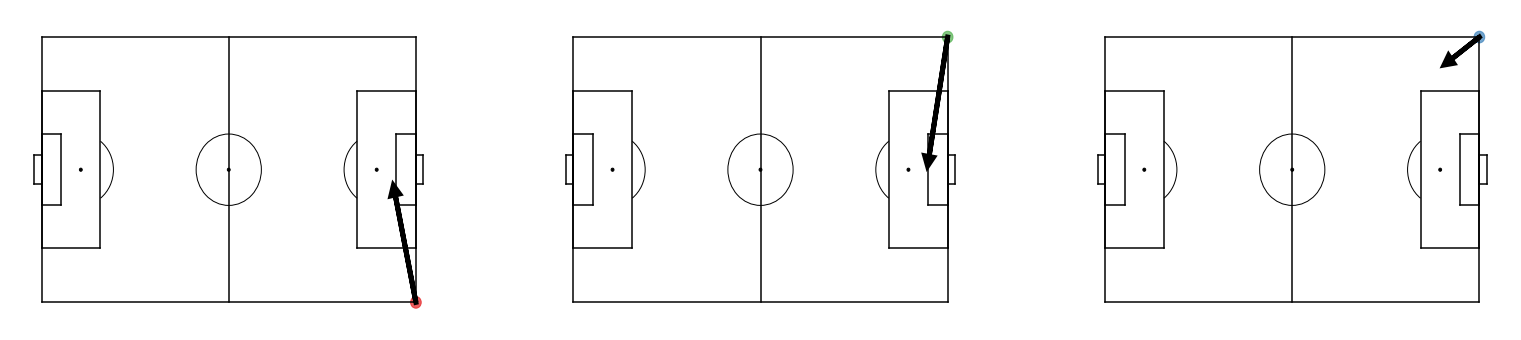

cross 2 1340


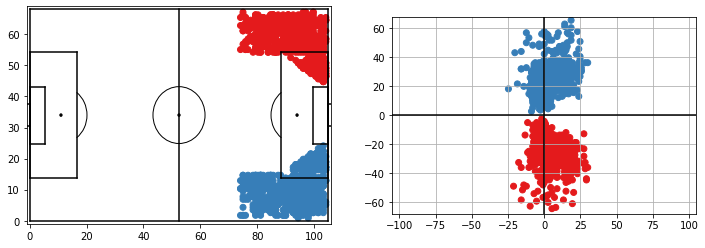

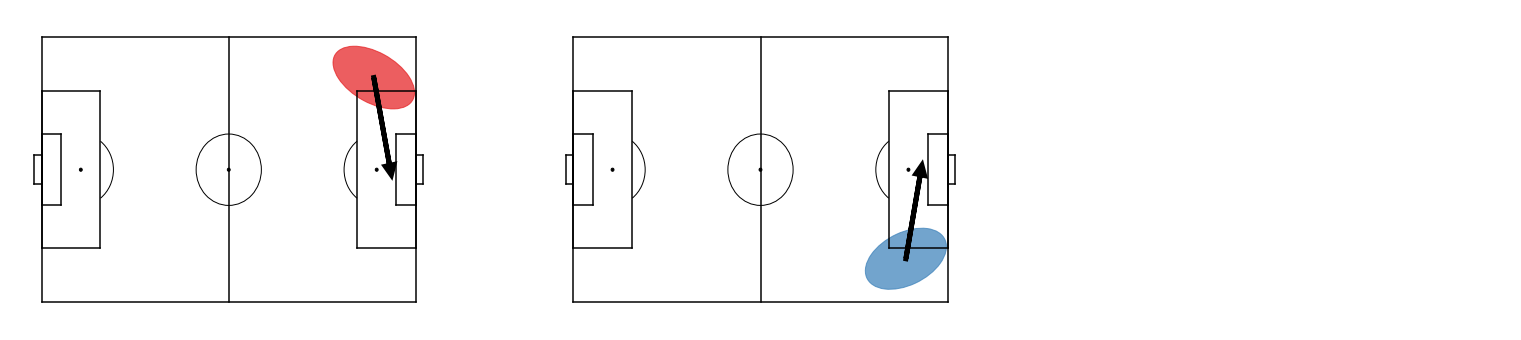

dribble 3 55786


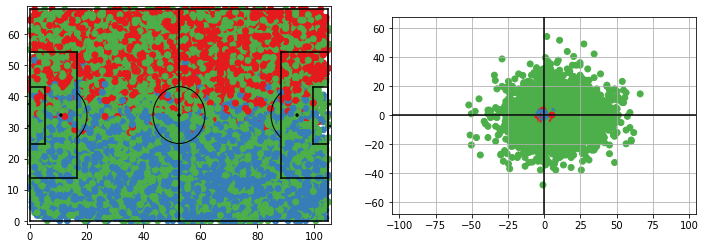

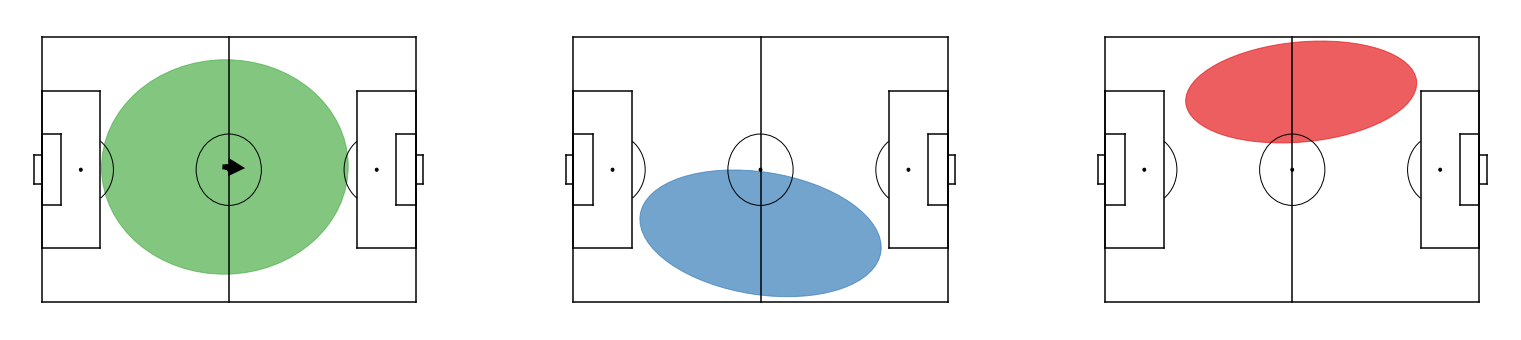

foul 10 1522


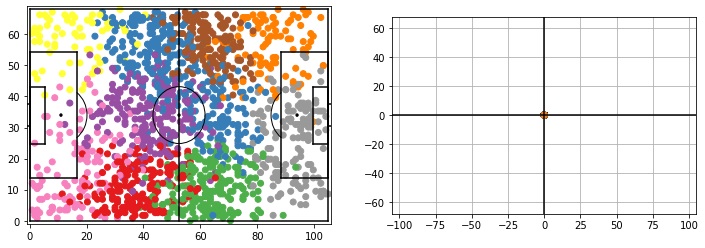

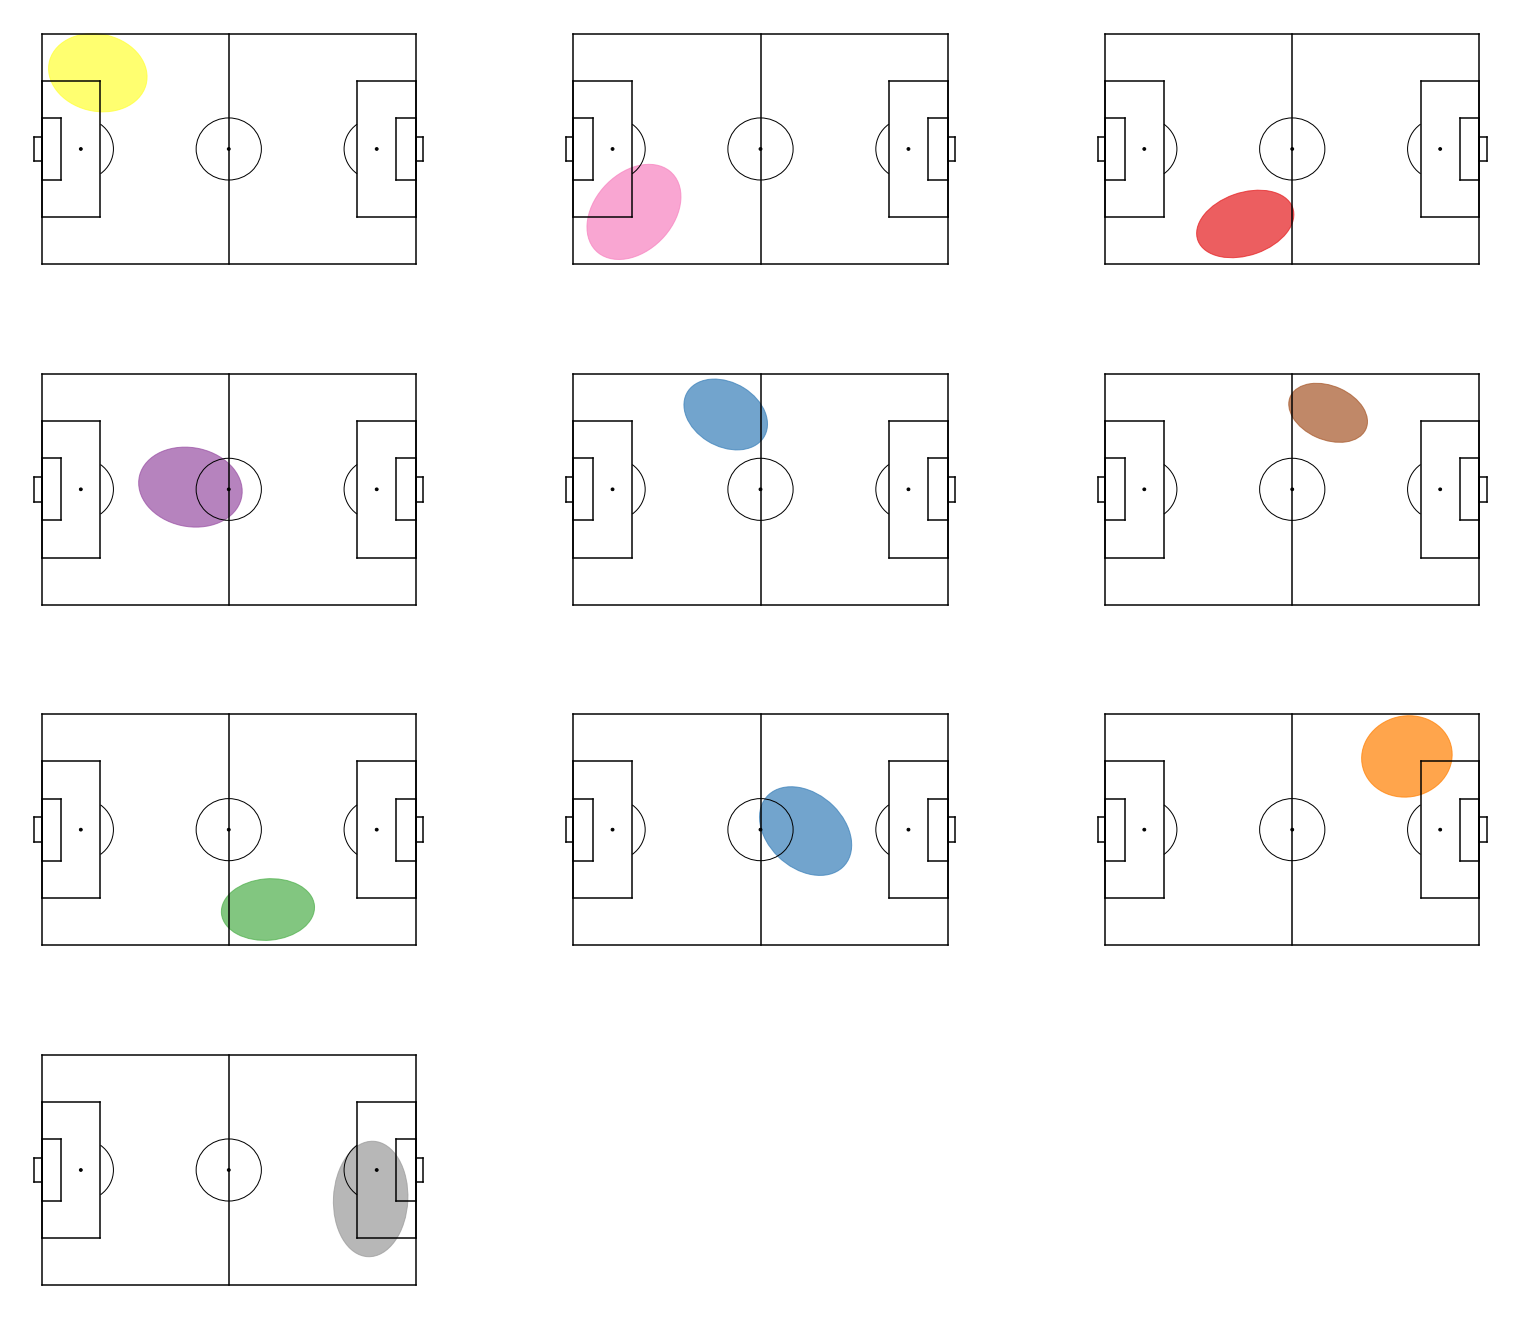

freekick 8 1485


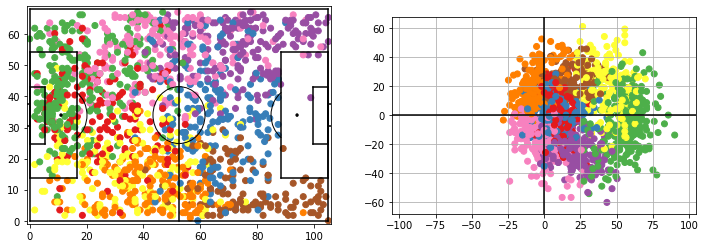

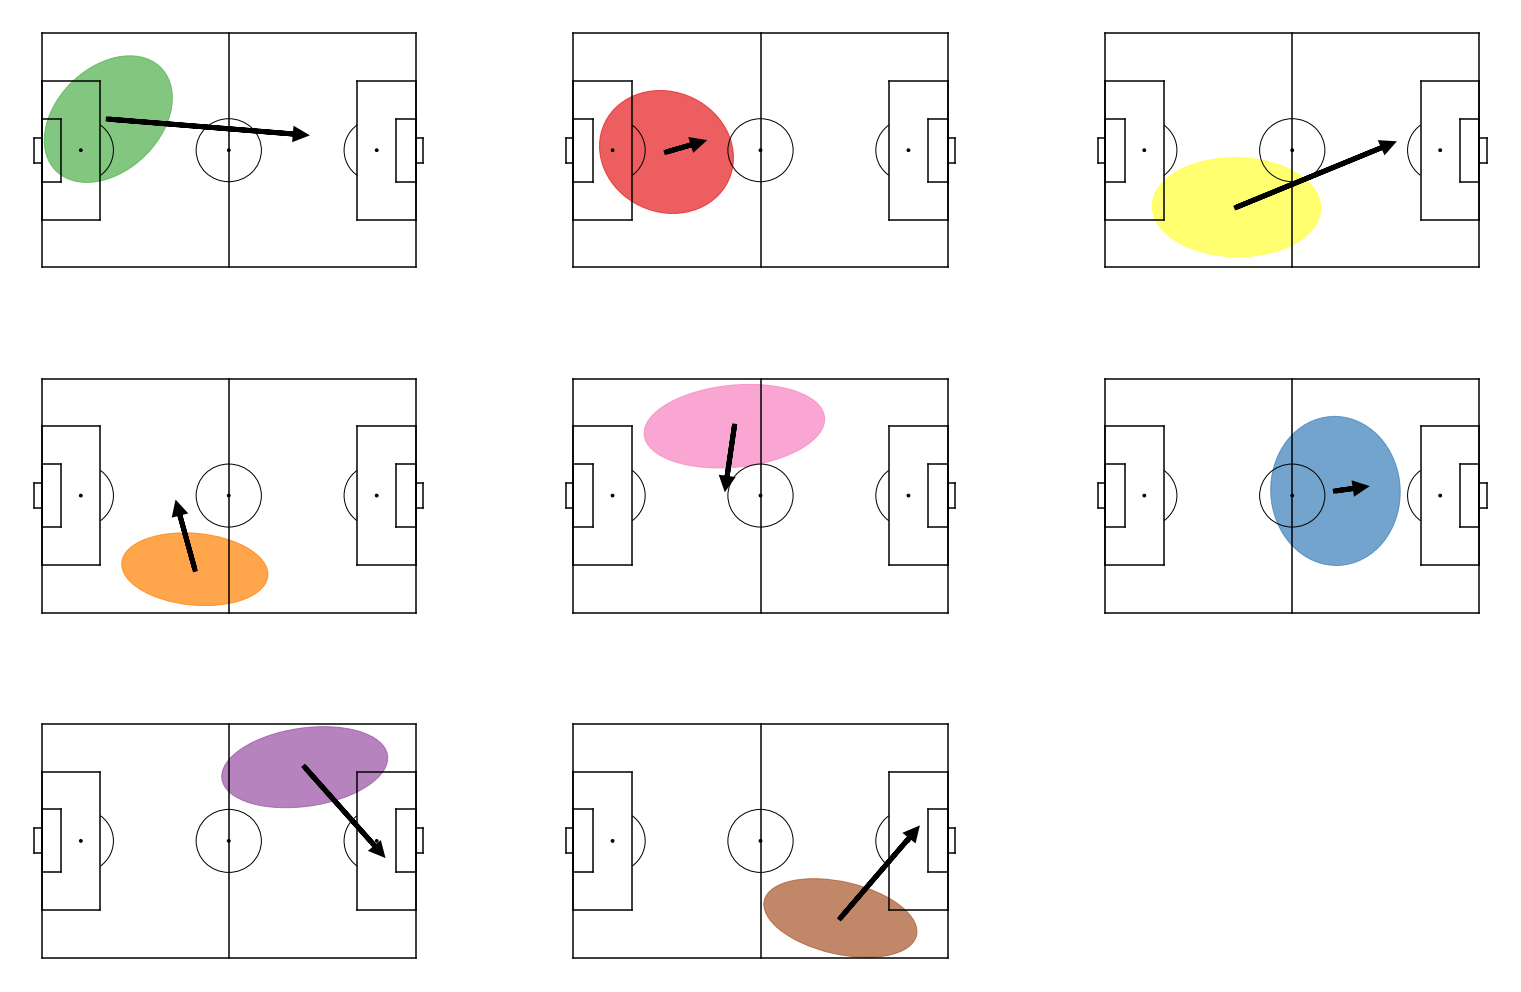

goal 1 181


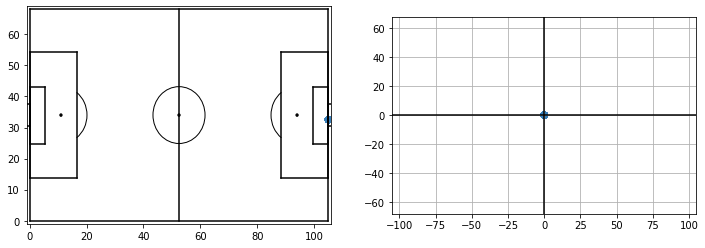

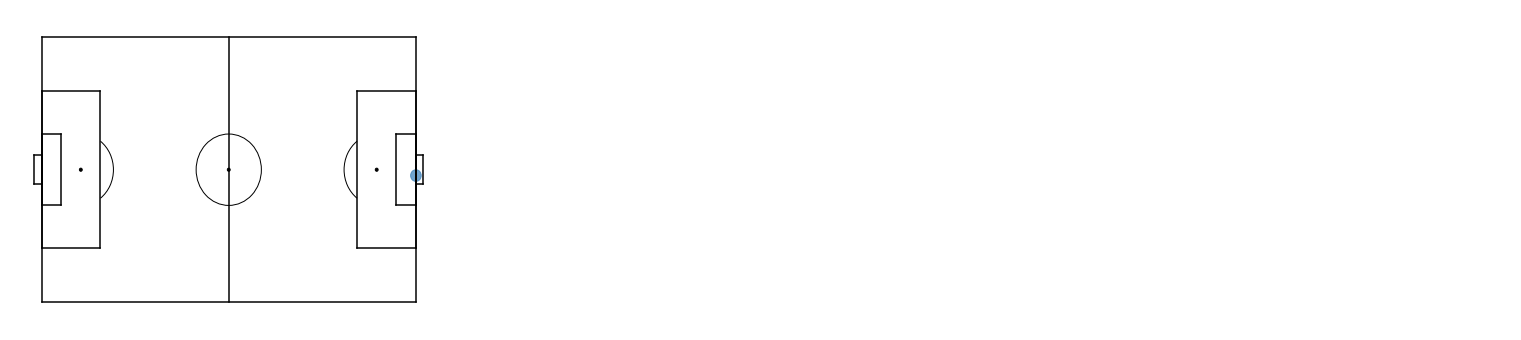

goalkick 5 957


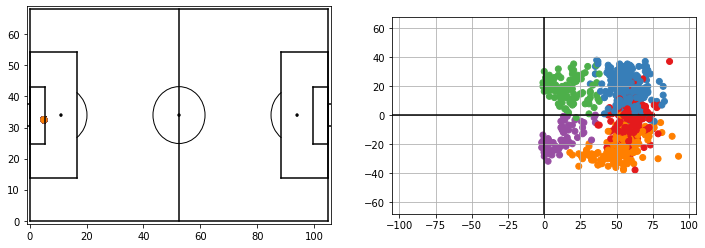

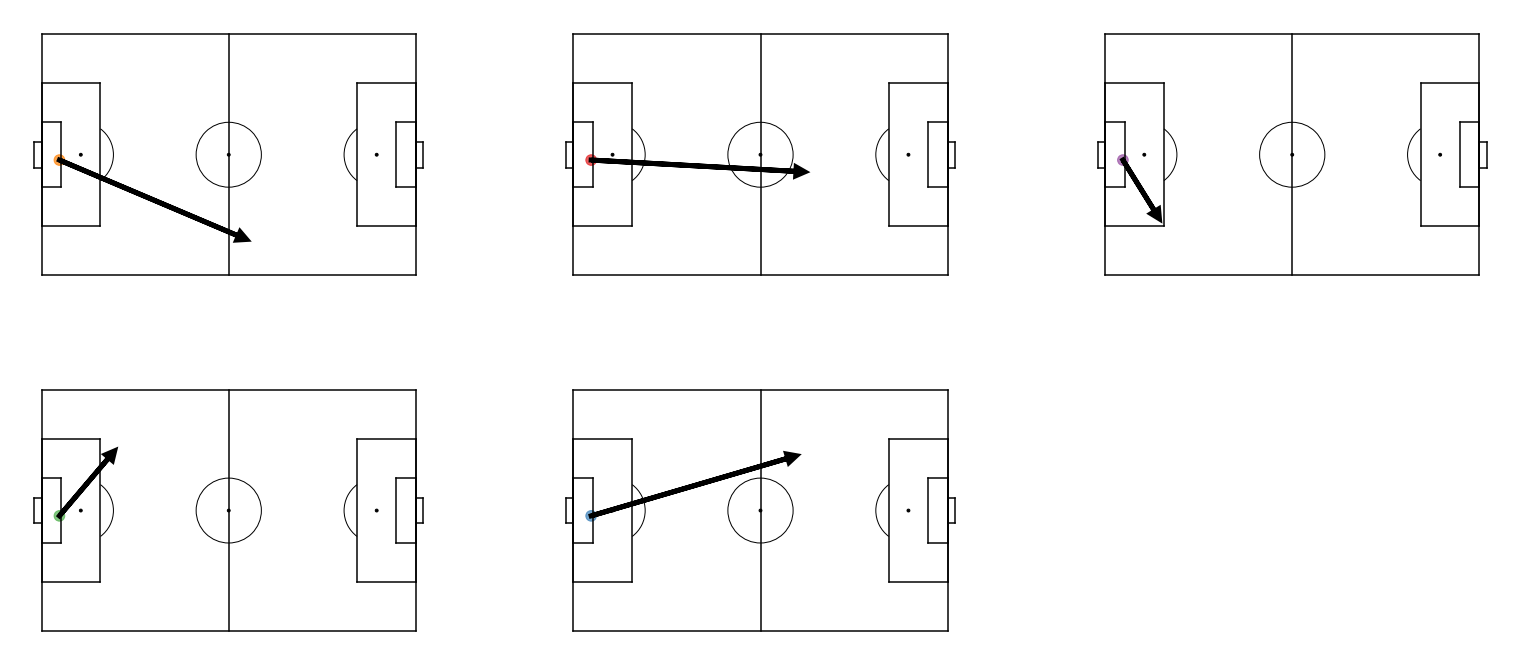

interception 7 12753


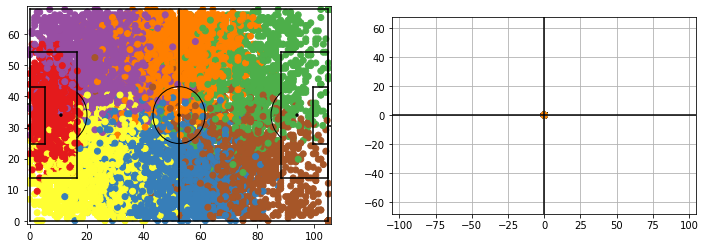

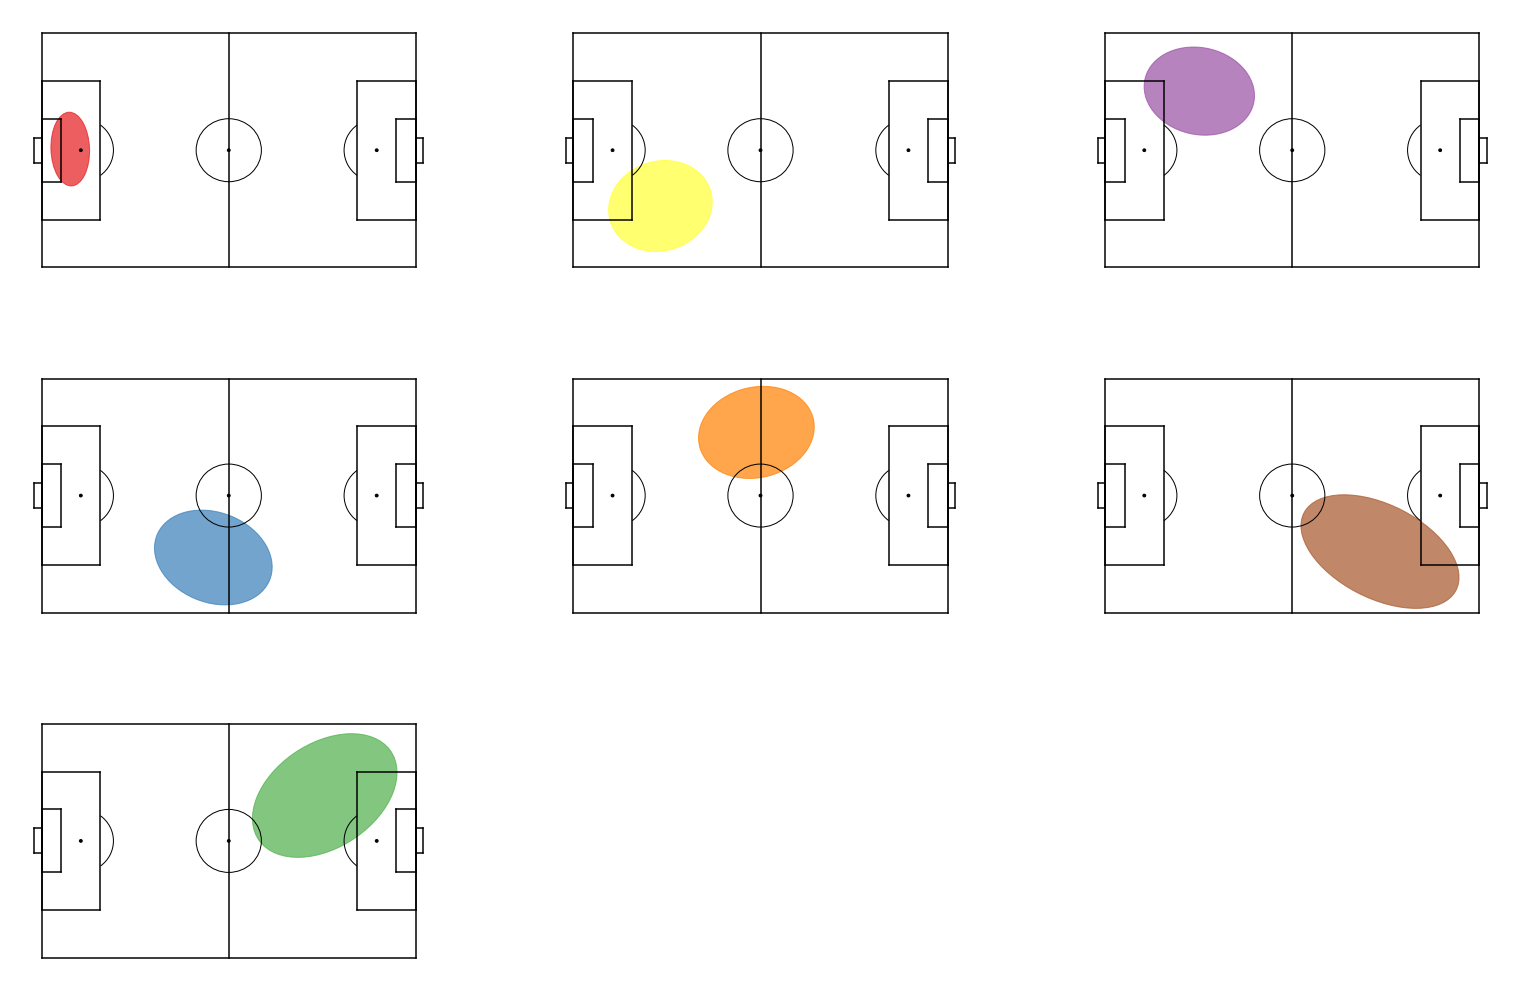

keeper_catch 1 641


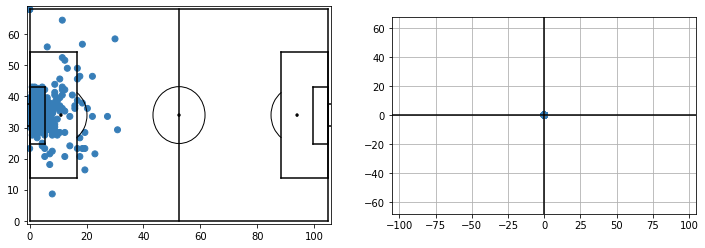

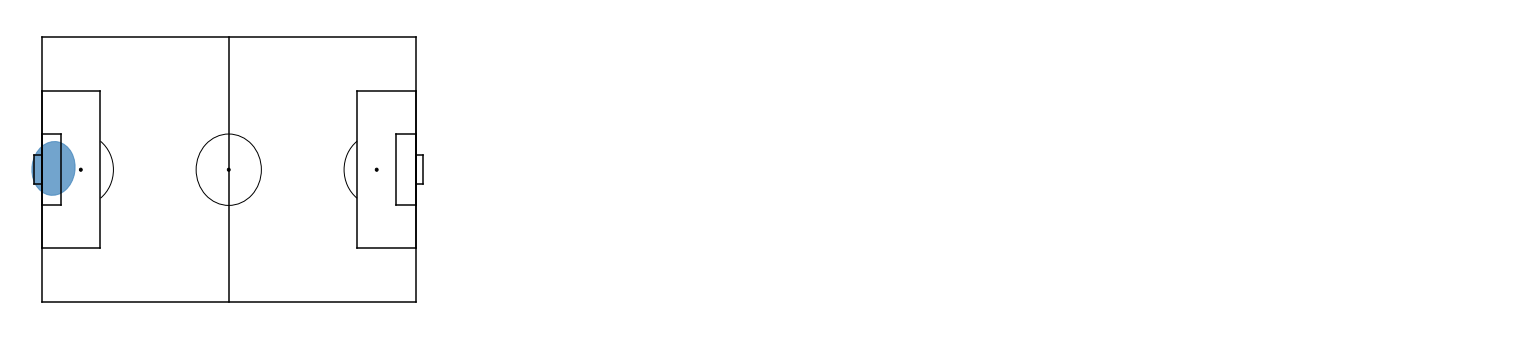

offside 5 207


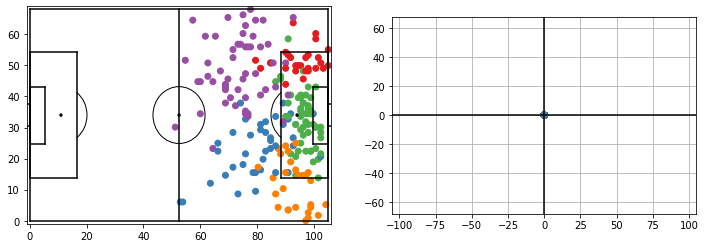

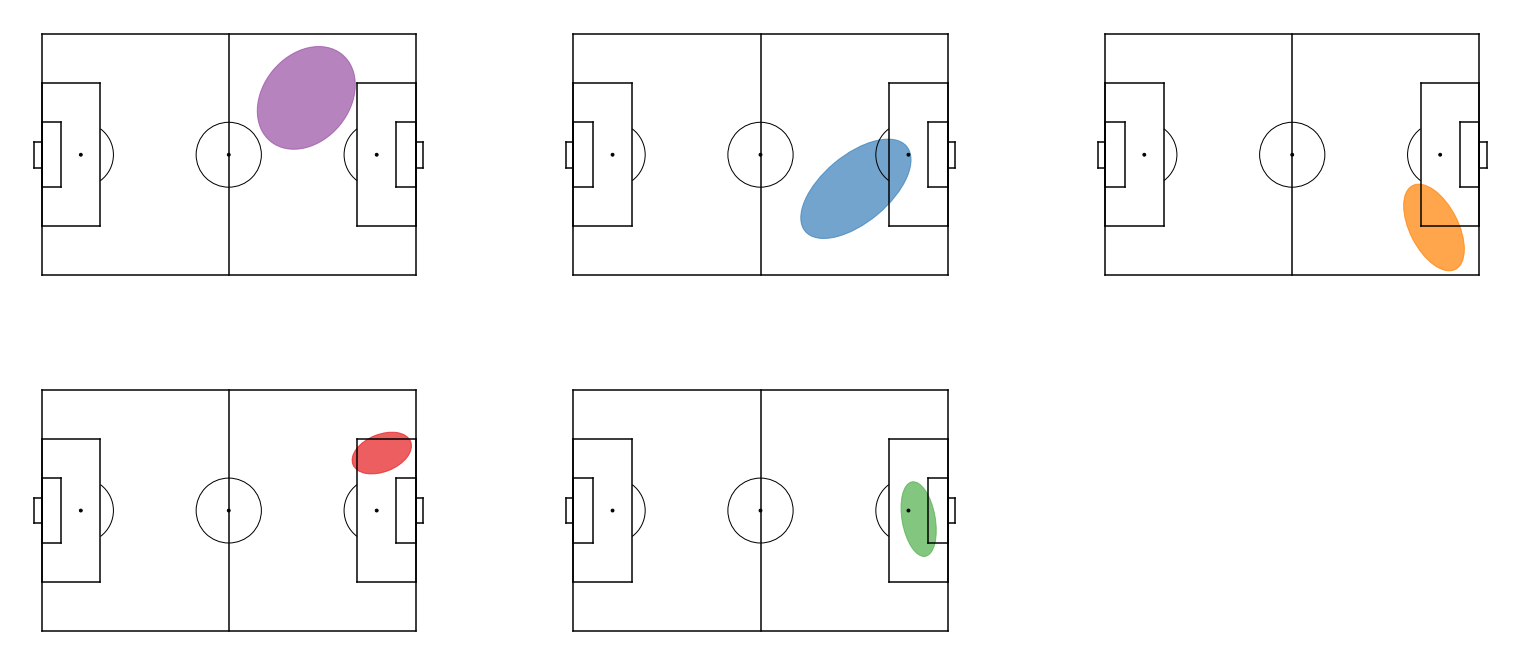

out 3 2555


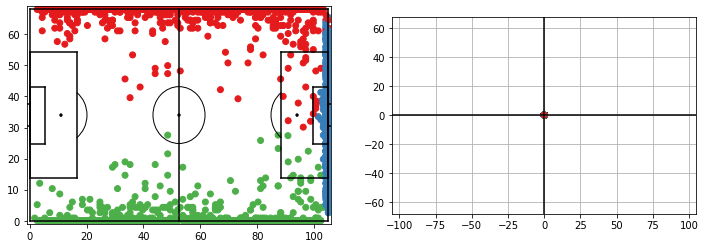

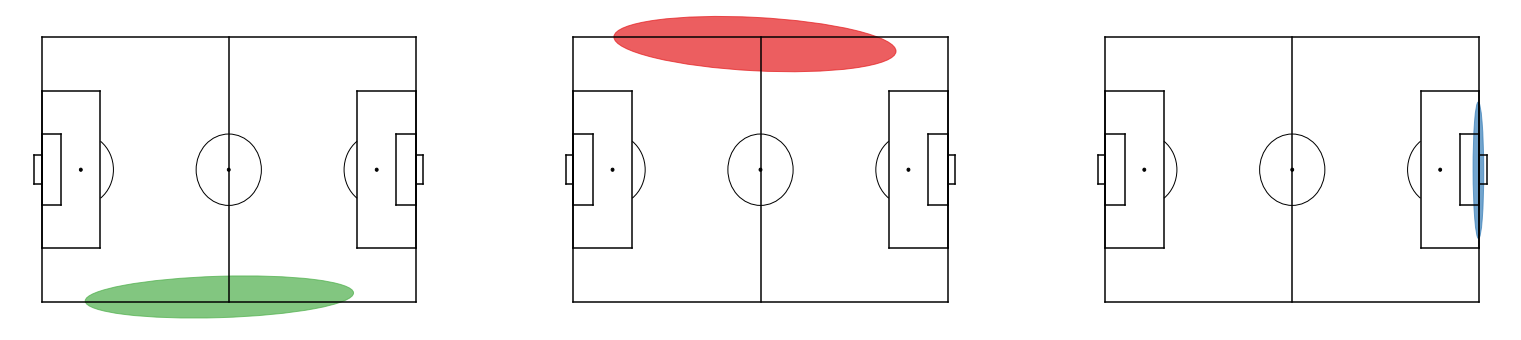

owngoal 1 2


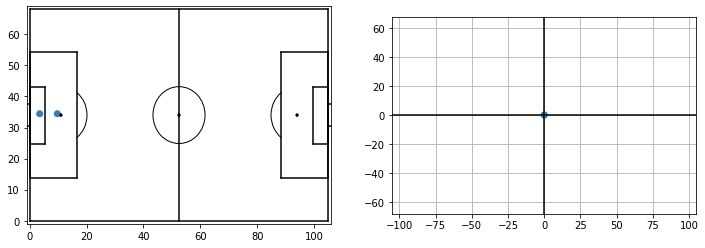

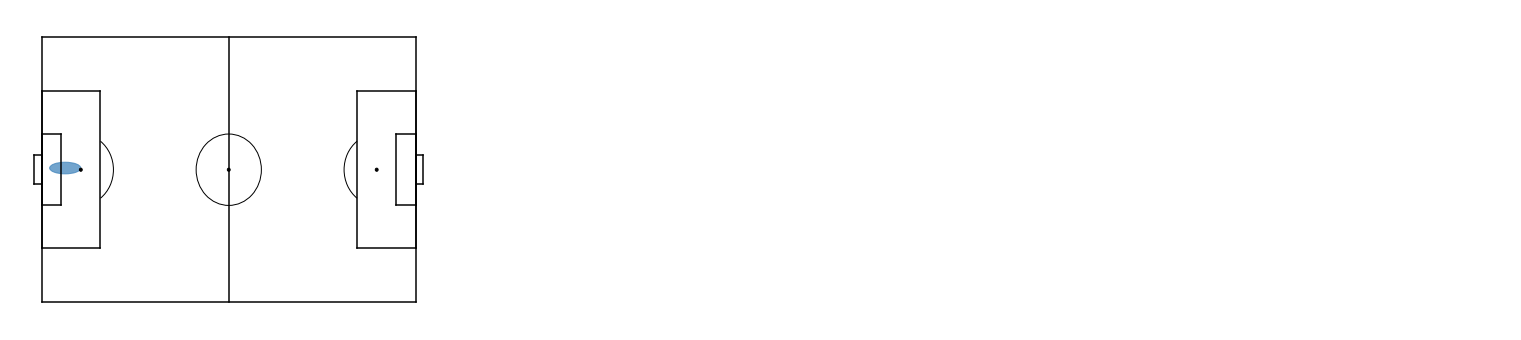

pass 7 56530


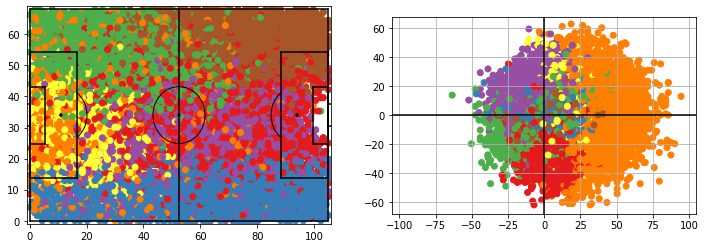

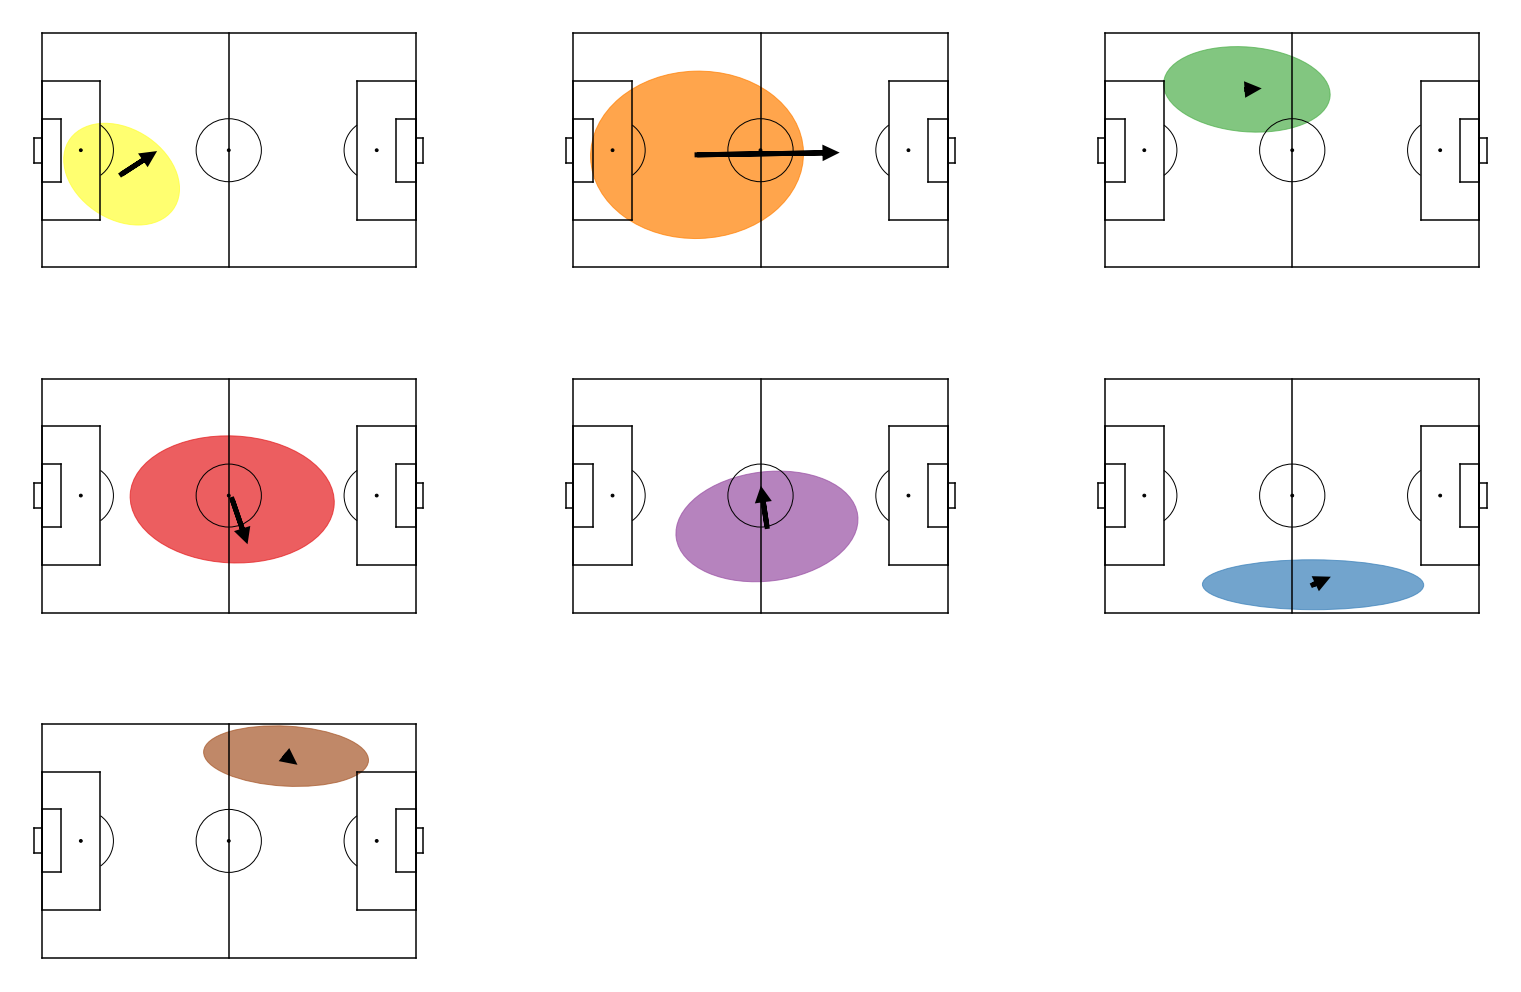

receival 6 51567


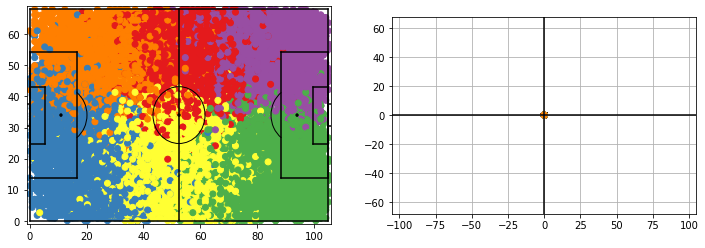

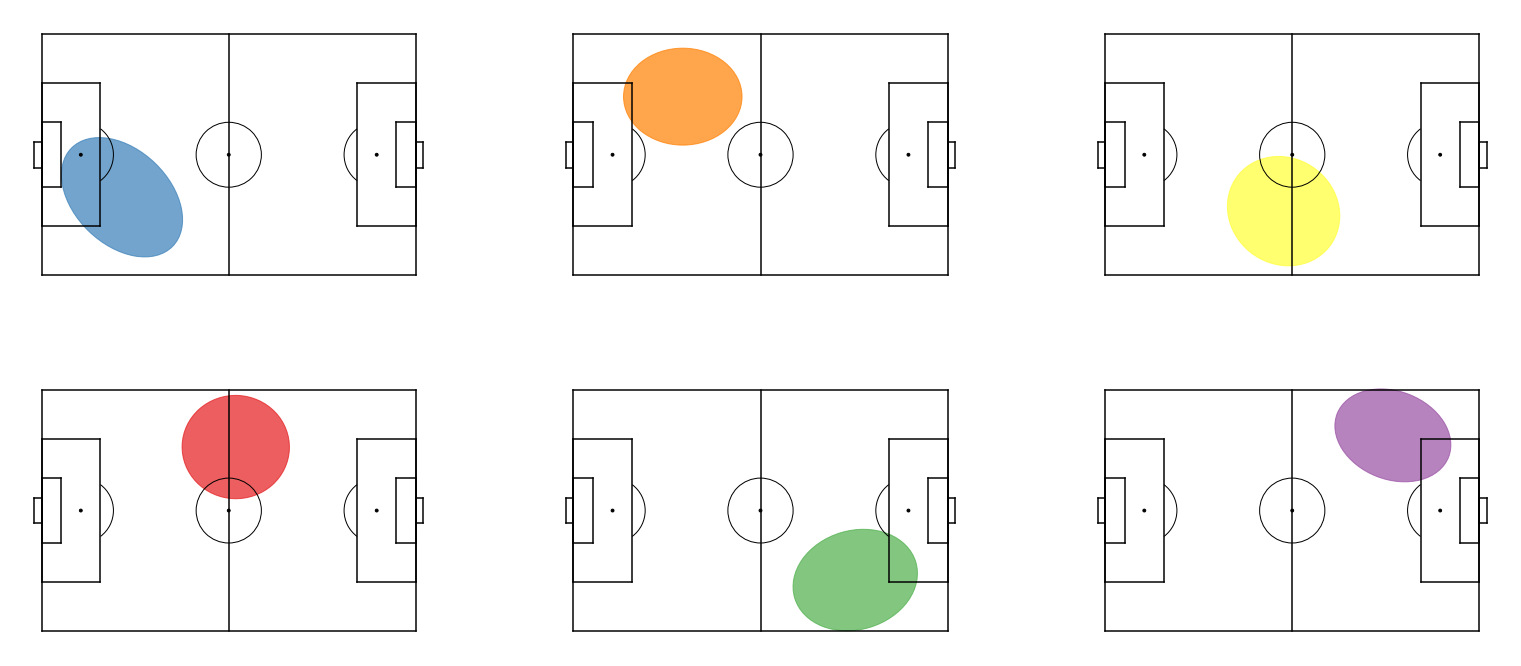

red_card 3 3


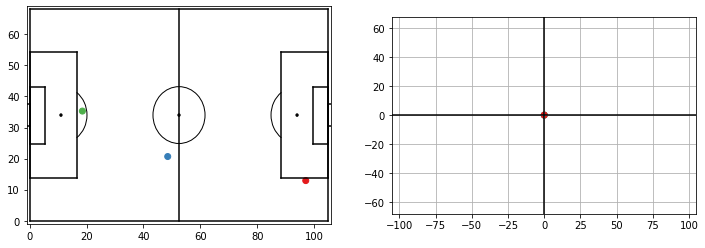

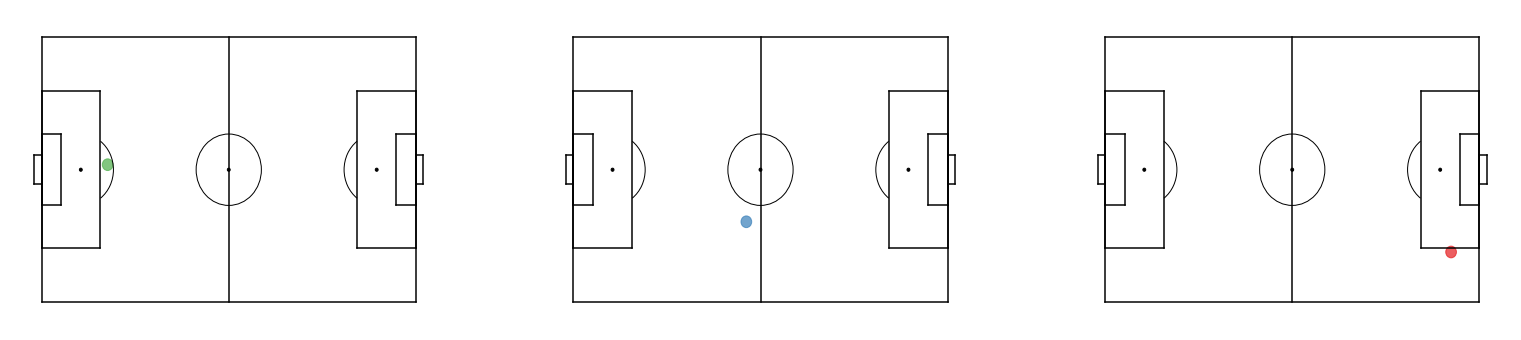

shot 2 1550


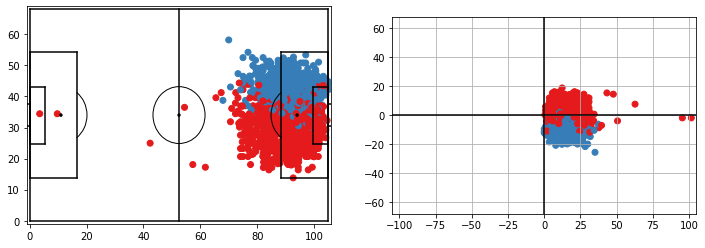

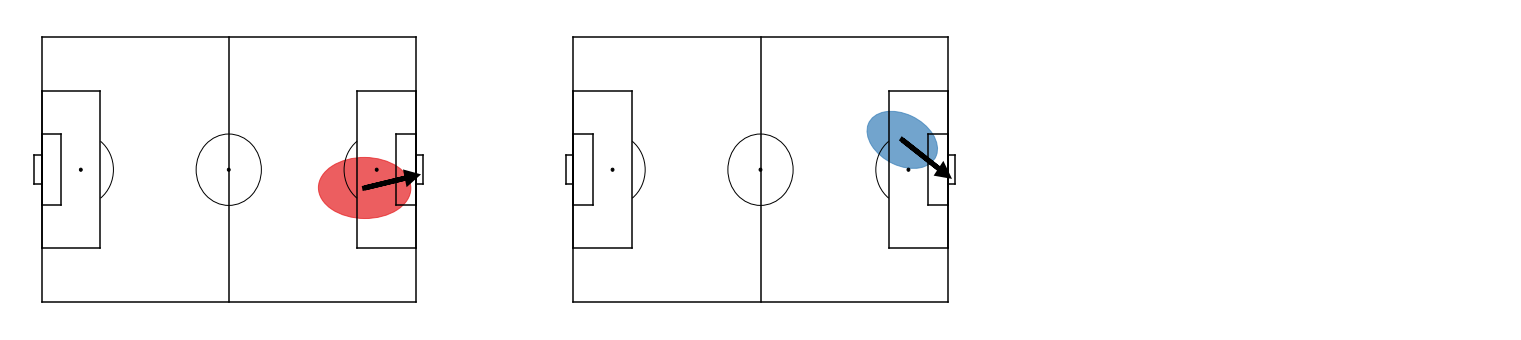

shot_penalty 1 19


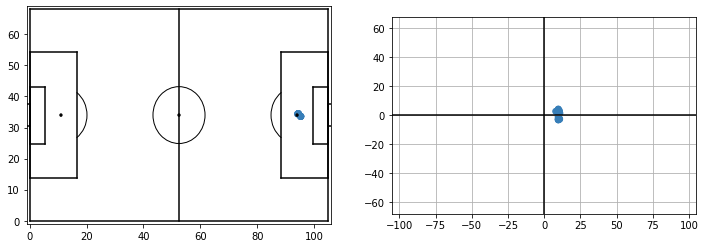

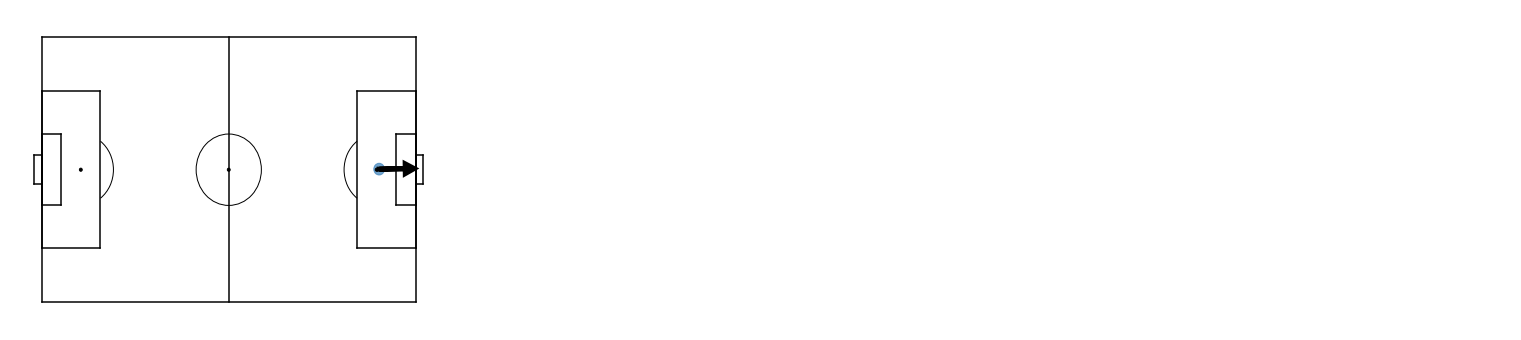

tackle 4 2281


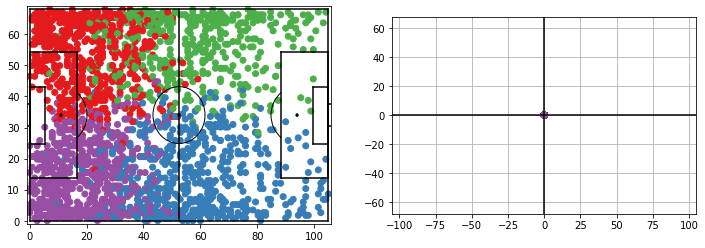

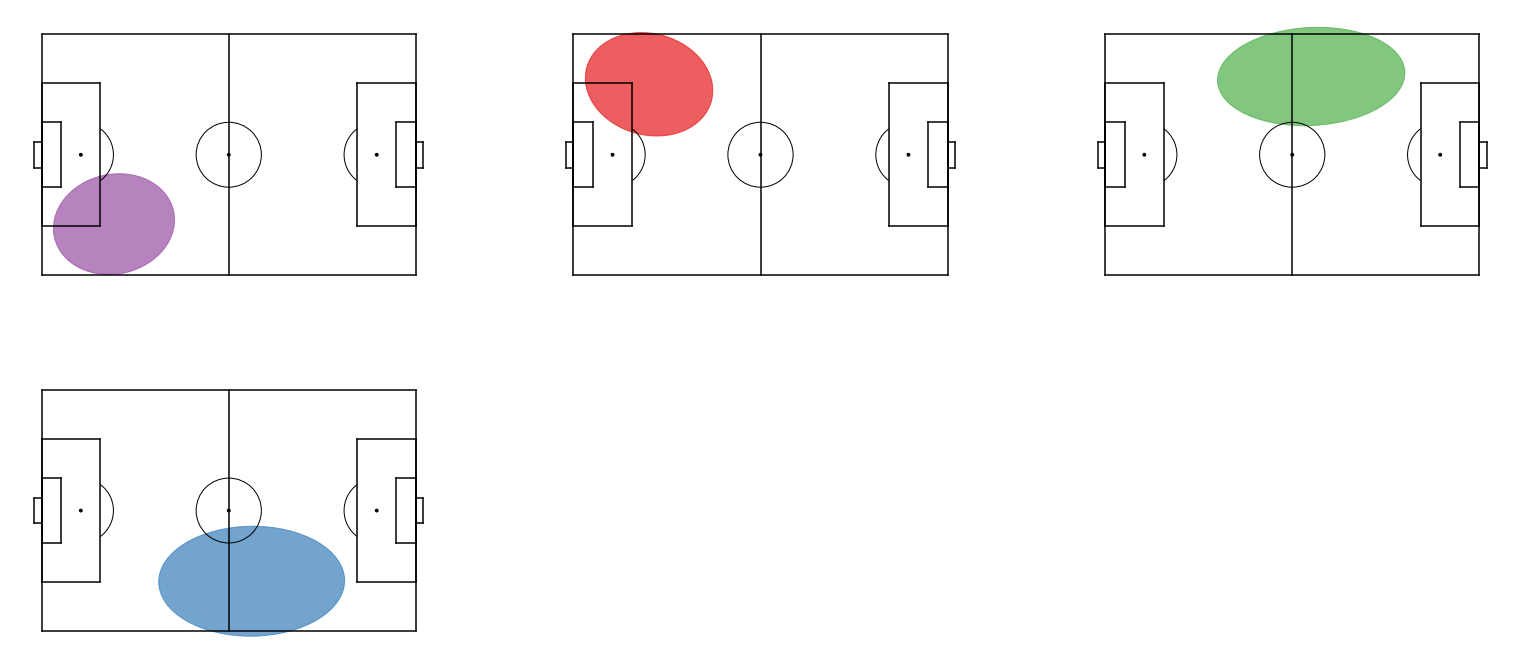

take_on 6 2112


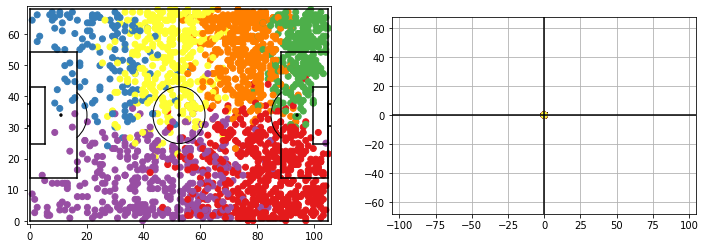

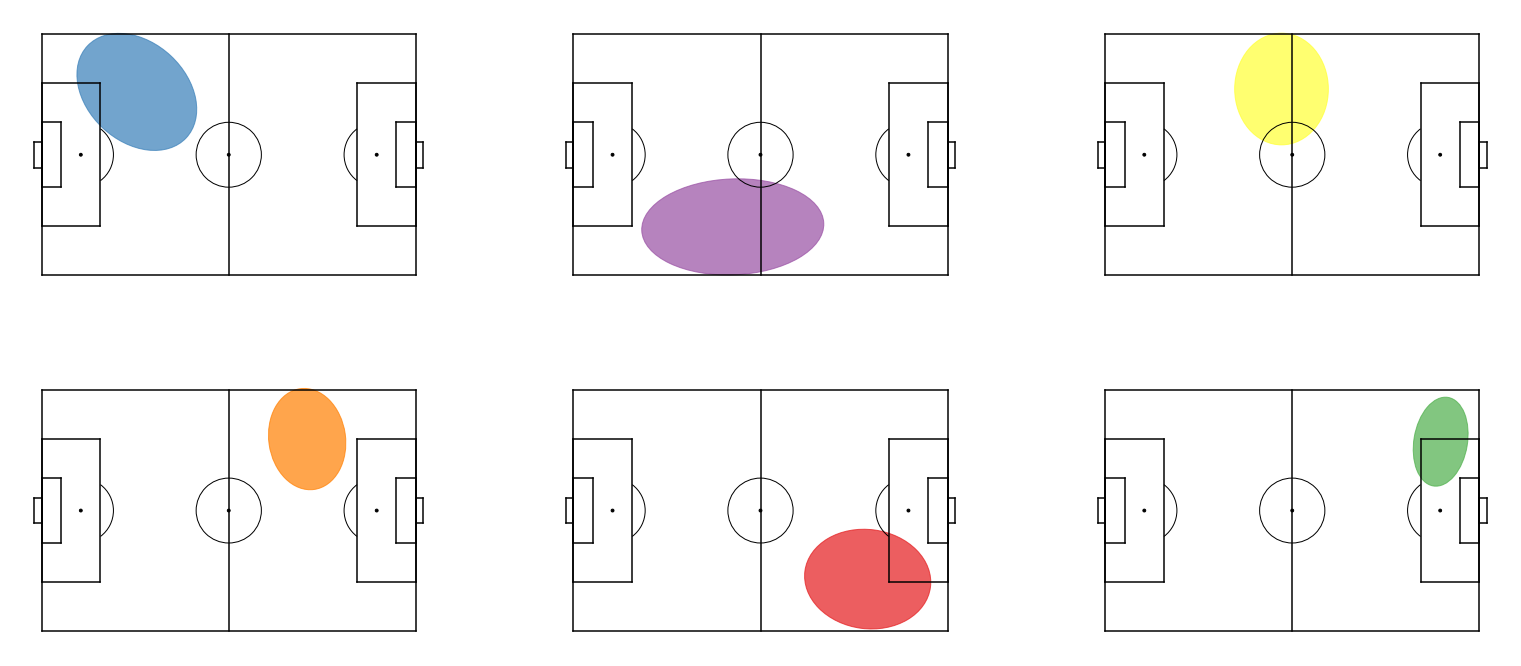

throw_in 9 2733


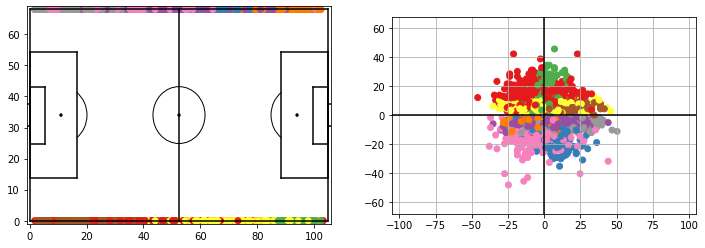

../pattern/vis.py:30: RuntimeWarning: divide by zero encountered in double_scalars
  angle = np.arctan(u[1] / u[0])


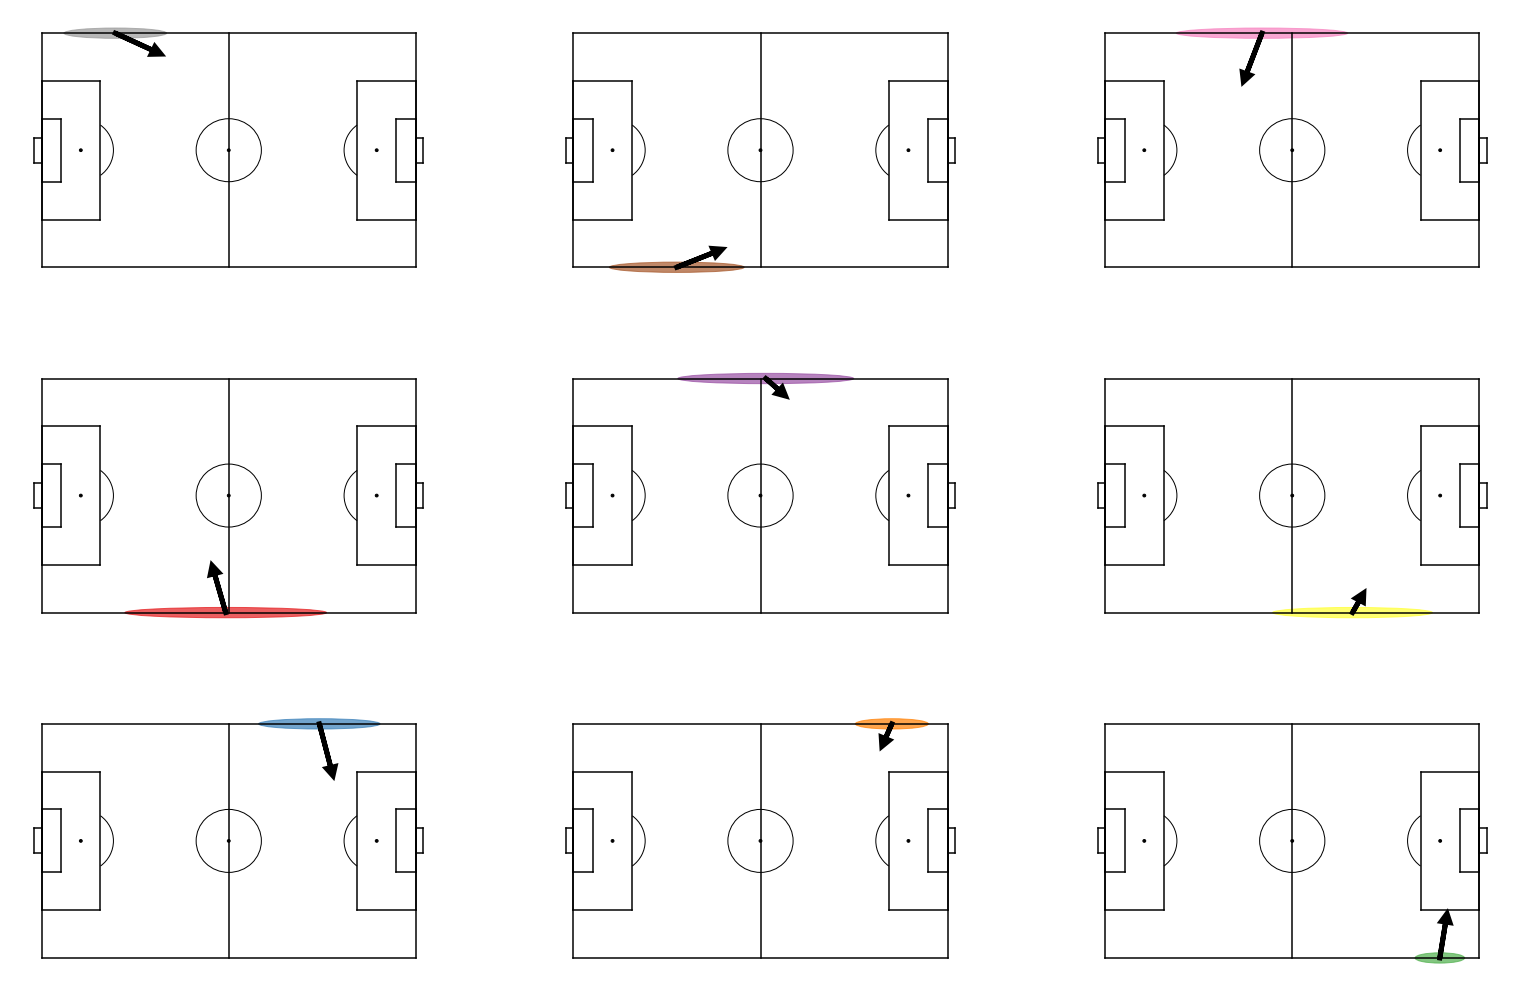

yellow_card 6 185


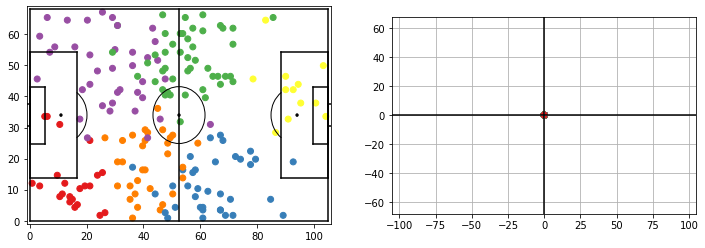

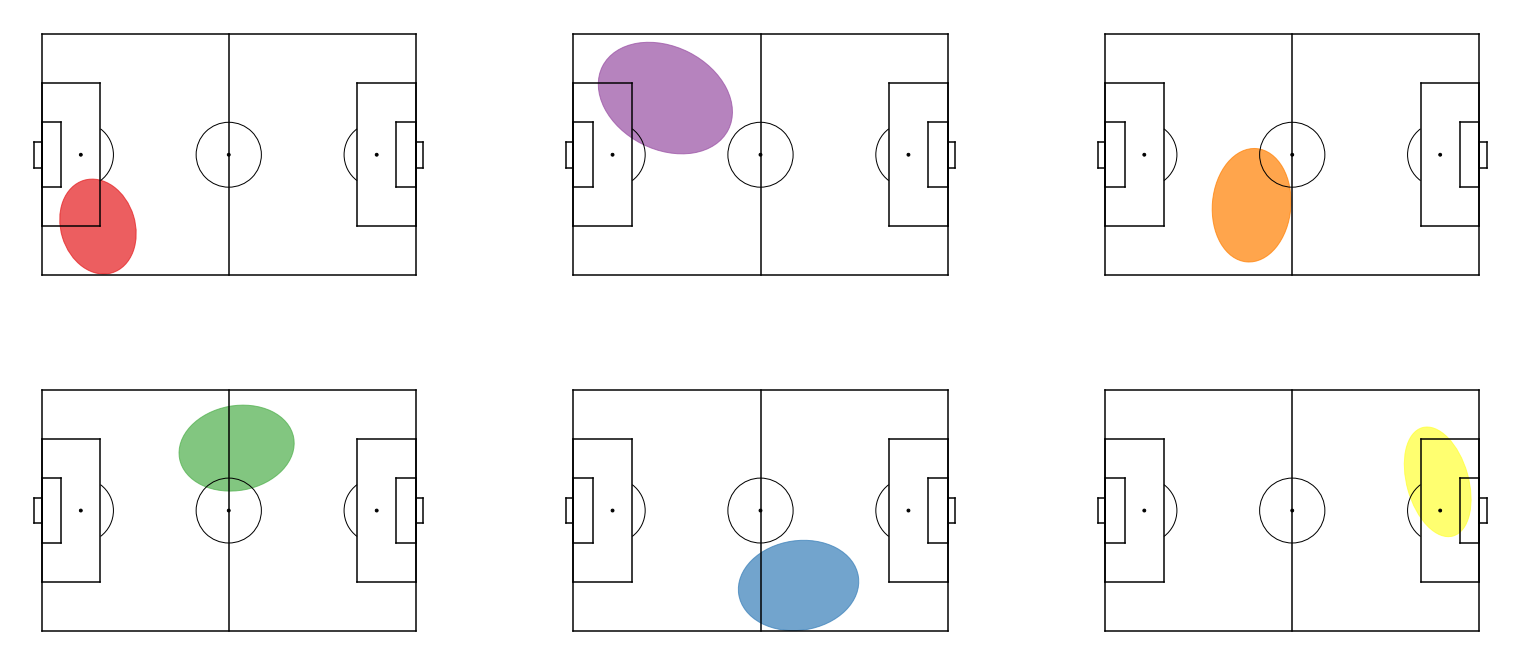

In [41]:
import pattern.vis as vis
for k, gmm in sorted(list(gmme.models.items())):
    df = a[a.type_name == k]
    print(k,gmm.n_components,len(df))
    #vis.plot_gmm(gmm)
    vis.plot_gmm_actions(gmm,df,gmme.cols,samplefn="uni")
    vis.plot_components_arrows(gmm,cols=3)

In [ ]:
probas = gmme.predict_proba(a)

In [ ]:
for ty in gmme.models:
    for k in range(gmme.models[ty].n_components):
        col = ty + str(k+1)
        print(col)
        v = probas[col].values
        
        fig,axs = plt.subplots(1,2)
        fig.set_size_inches(3*6,6)
        axs[0].hist(v[v>0.01])
        mps.field(ax=axs[1],show=False)
        vis.plot_component_w_arrow(gmme.models[ty],k,ax=axs[1])
        plt.show()

In [ ]:
ucprobas = pat.uncouple_probabilities(probas,a.is_home.values)
ucprobas
ucprobas.values.sum()

In [ ]:
prev = ucprobas.values[:-1]
nex = ucprobas.values[1:]
print(prev.shape)
trans = np.dot(prev.T,nex)
plt.matshow(trans)
plt.colorbar()
plt.show()
trans /= trans.sum()
# for i in range(len(trans[0])):
#     trans[i,:] /= trans[i,:].sum()
trans.sum()
ori_trans = trans

In [ ]:
trans1 = ori_trans.copy()
for _i in range(10):
    print(trans1.sum())
    trans1 = np.dot(ori_trans.T,trans1)
    trans1 /= trans1.sum()

In [ ]:
delta_trans = trans1 - ori_trans
plt.matshow(delta_trans)
plt.colorbar()
plt.show
delta_trans.max(), delta_trans.min()

In [ ]:
trans = delta_trans
trans = trans1

In [ ]:
trans.sum()

In [ ]:
plt.hist([p for p,i,j in probs])
plt.show()

In [ ]:
probs = []
for i in range(len(trans)):
    for j in range(len(trans)):
        probs.append((trans[i,j],i,j))
probs = sorted(probs,reverse=True)
movs = [(p,i,j) for p,i,j in probs]# if i != j]

cols = list(ucprobas.columns)

def test(i,j):
    return True
    return "goal1" in cols[j]# and "opp" not in cols[j]
    return "shot" in cols[i] and "opp" not in cols[j]

interestmovs = [(p,i,j) for p,i,j in movs 
                if test(i,j)
                #"pass" not in cols[i]
                   # and "receival" not in cols[i]
                   # and "dribble" not in cols[i]
               ]

for p,i,j in interestmovs[:10]:
    print(p,i,j)
    print(cols[i],"(red)","->",cols[j],"(blue)")
    ax = mps.field(show=False)
    ty,k = gmme._global_to_local(i % gmme.total_components())
    is_opp = i > gmme.total_components() - 1
    vis.plot_component_w_arrow(gmme.models[ty],k,ax=ax,color="red",mirror=is_opp,show=False)
    ty,k = gmme._global_to_local(j % gmme.total_components())
    is_opp = j > gmme.total_components() - 1
    vis.plot_component_w_arrow(gmme.models[ty],k,ax=ax,color="blue",mirror=is_opp,show=False)
    plt.show()

In [ ]:
labels = np.argmax(probas.values,axis=1)

for p,i,j in movs[:10000]:
    cols = gmme._columns()
    if "shot" in cols[j] and "kick" not in cols[j]:# or True:
        print(p,i,j)
        print(cols[i],"(blue)","->",cols[j],"(red)")
        l_idx = (labels == i) | (labels == j)
        twocolors = ["blue" if l == i else "red" for l in labels[l_idx]]
        axs = vis.locmovaxes()
        axs[0].scatter(a.x[l_idx],a.y[l_idx],color=twocolors)
        axs[1].scatter(a.dx[l_idx],a.dy[l_idx],color=twocolors)
        plt.show()
    if p < 50:
        break

In [ ]:
labels = np.argmax(probas.values,axis=1)

for p,i,j in movs[:10000]:
    cols = gmme._columns()
    if "shot" in cols[j] and "kick" not in cols[j]:# or True:
        print(p,i,j)
        print(cols[i],"(blue)","->",cols[j],"(red)")
        l_idx = (labels == i) | (labels == j)
        twocolors = ["blue" if l == i else "red" for l in labels[l_idx]]
        axs = vis.locmovaxes()
        axs[0].scatter(a.x[l_idx],a.y[l_idx],color=twocolors)
        axs[1].scatter(a.dx[l_idx],a.dy[l_idx],color=twocolors)
        plt.show()
    if p < 5:
        break